# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# generic   
import time
import pickle
import itertools as it
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [x['color'] for x in plt.style.library['seaborn']['axes.prop_cycle']]
from mpl_toolkits import mplot3d

# load the model module
from HighFreqIncProcess import HighFreqIncProcessClass
import estimate
from labels import latex

**Set various settings:**

In [2]:
DO_TRIAL = False
LOAD = False

In [3]:
cutoff = 1e-8

# Setup

In [4]:
# a. setup
par = {'use_equal_weighting':True} # changes to baseline parameters
data = HighFreqIncProcessClass(name='identification_data',par=par)

# b. moment specifications
data.set_specs()

# c. estimation parameters
data.theta = {

    'p_phi': {'guess':np.nan,'lower':0.005,'upper':0.30},
    'p_psi': {'guess':np.nan,'lower':0.005,'upper':0.30},
    'p_eta': {'guess':np.nan,'lower':0.025,'upper':0.30},
    'p_xi': {'guess':np.nan,'lower':0.025,'upper':0.30}, 
    
    'sigma_phi': {'guess':np.nan,'lower':0.01,'upper':0.20,'closed_form':True},    
    'sigma_psi': {'guess':np.nan,'lower':0.05,'upper':0.50,'closed_form':True},    
    'sigma_eta': {'guess':np.nan,'lower':0.05,'upper':1.00,'closed_form':True},
    'sigma_xi': {'guess':np.nan,'lower':0.05,'upper':1.00},
    
    'rho': {'guess':np.nan,'lower':0.00,'upper':1.0,'closed_form':True},
    
    'mu_xi': {'guess':np.nan,'lower':0.01,'upper':1.00},
    'mu_phi': {'guess':np.nan,'lower':-0.05,'upper':0.05,'closed_form':True},

}

**Calculate moments:**

In [5]:
data.calc_moments()

**Test closed form estimates**

In [6]:
closed_form = estimate.construct_closed_form(data.par,data.moms)
for key in ['rho','mu_phi','sigma_psi','sigma_phi','sigma_eta']:
    print(f'{key:10s}: {closed_form[key]:12.4f} (estimated) vs. {getattr(data.par,key):12.4f} (true)')

rho       :       0.9000 (estimated) vs.       0.9000 (true)
mu_phi    :       0.0200 (estimated) vs.       0.0200 (true)
sigma_psi :       0.1500 (estimated) vs.       0.1500 (true)
sigma_phi :       0.0500 (estimated) vs.       0.0500 (true)
sigma_eta :       0.0200 (estimated) vs.       0.0200 (true)


**Load data and prepare later estimation**

In [7]:
model = data.copy()
model.name = 'identification'
model.latexname = 'identification'
model.load_datamoms(data)
model.prepare_estimation()

# Trial estimation

In [8]:
if DO_TRIAL:
    true = {key:getattr(data.par,key) for key in model.theta.keys()}
    model.draw_initial_guesses()
    model.identification_estimation(do_print=True,true=true)
    model.est_vs_true(data)
    model.compare_moments()

# Experiments

In [9]:
model.test_identification(load=LOAD)        

C:\Users\gmf123.UNICPH\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


total time: 240min 34s (avg. cpu load: 72.6)


**Overview:**

In [10]:
for cutoff_now in [np.inf,1e-6,1e-7,1e-8]:
    print(f'cutoff = {cutoff_now}')
    model.identification_results(cutoff=cutoff_now)
    print('')

cutoff = inf
             min-max diff.
p_phi      :  -0.00   0.00
p_psi      :  -0.00   0.00
p_eta      :  -0.03   0.00
p_xi       :  -0.00   0.03
sigma_phi  :  -0.00   0.01
sigma_psi  :  -0.00   0.00
sigma_eta  :  -0.02   0.01
sigma_xi   :  -0.01   0.01
rho        :  -0.05   0.01
mu_xi      :  -0.04   0.01
mu_phi     :  -0.00   0.00

max obj.: 0.00000381
share < cutoff: 1.000
max diff. in par: 0.05081876

cutoff = 1e-06
             min-max diff.
p_phi      :  -0.00   0.00
p_psi      :  -0.00   0.00
p_eta      :  -0.03   0.00
p_xi       :  -0.00   0.03
sigma_phi  :  -0.00   0.01
sigma_psi  :  -0.00   0.00
sigma_eta  :  -0.02   0.00
sigma_xi   :  -0.01   0.01
rho        :  -0.05   0.01
mu_xi      :  -0.04   0.01
mu_phi     :  -0.00   0.00

max obj.: 0.00000100
share < cutoff: 0.982
max diff. in par: 0.05081876

cutoff = 1e-07
             min-max diff.
p_phi      :  -0.00   0.00
p_psi      :  -0.00   0.00
p_eta      :  -0.03   0.00
p_xi       :  -0.00   0.03
sigma_phi  :  -0.00   0.00

**Compare true and estimated:**

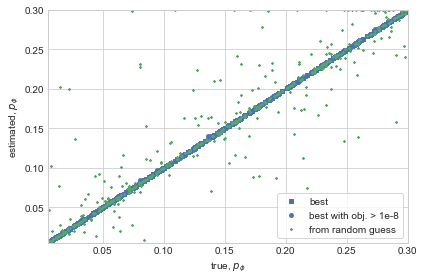

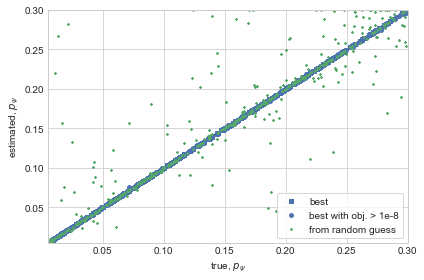

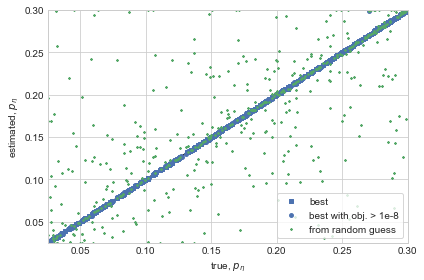

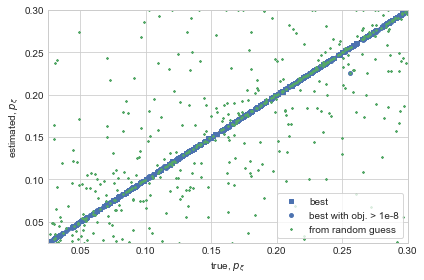

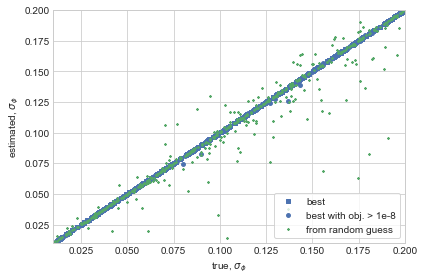

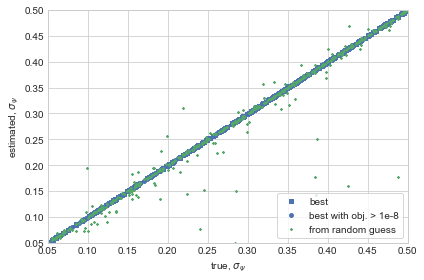

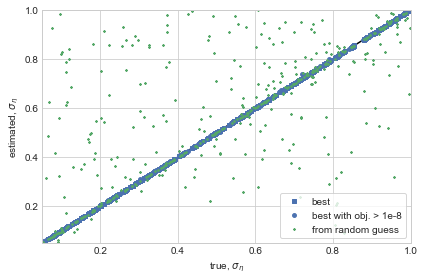

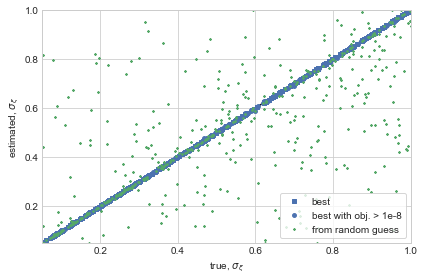

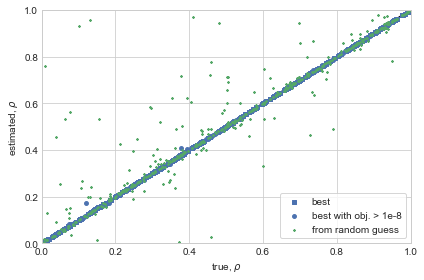

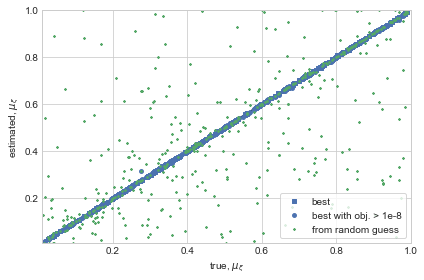

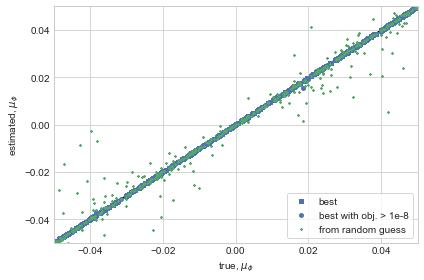

In [11]:
for name in model.theta.keys():
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    true = np.array([est['true'][name] for est in model.est['ests'] if est['obj'] < cutoff]) 
    est = np.array([est['est'][name] for est in model.est['ests'] if est['obj'] < cutoff])
    ax.scatter(true,est,label='best',marker='s',s=15,c=colors[0])
    
    true = np.array([est['true'][name] for est in model.est['ests'] if est['obj'] >= cutoff]) 
    est = np.array([est['est'][name] for est in model.est['ests'] if est['obj'] >= cutoff])
    ax.scatter(true,est,label='best with obj. > 1e-8',marker='o',s=15,c=colors[0])
    
    true = np.array([est['true'][name] for est in model.est['ests']])
    est = np.array([est['est_A'][name] for est in model.est['ests']])
    ax.scatter(true,est,label='from random guess',marker='x',s=3,c=colors[1])

    lims = [model.theta[name]['lower'],model.theta[name]['upper']]
    ax.plot(lims,lims,color='black',zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    ax.legend(frameon=True,loc='lower right')
    
    ax.set_xlabel(f'true, {latex[name](data.par)[1]}')
    ax.set_ylabel(f'estimated, {latex[name](data.par)[1]}')
    
    fig.tight_layout()
    fig.savefig(f'figs/identification_{name}.pdf')